# Twitter Account Analytics
- **Created by Andrés Segura Tinoco**
- **Created on May 24, 2020**

In [1]:
# Import util libraries
import tweepy
import random
import numpy as np
import pandas as pd
import yaml
import warnings
import calendar
from datetime import date
from collections import Counter
from PIL import Image

In [2]:
# Import NLP libraries
import re
import spacy.lang.es as es
import spacy.lang.en as en
from wordcloud import WordCloud

In [3]:
# Import plot libraries
import matplotlib.pyplot as plt

In [4]:
warnings.filterwarnings('ignore')

## 1. Create connection to the Tweepy API

In [5]:
# Util function - Read dict from yaml file
def get_dict_from_yaml(yaml_path):
    result = dict()
    
    with open(yaml_path) as f:
        yaml_file = f.read()
        result = yaml.load(yaml_file, Loader=yaml.FullLoader)
    
    return result

In [6]:
# Read twitter bot credentials
yaml_path = 'config\credentials.yml'
twt_login = get_dict_from_yaml(yaml_path)

# Setup bot credentials
consumer_key = twt_login['consumer_key']
consumer_secret = twt_login['consumer_secret']
access_token = twt_login['access_token']
access_token_secret = twt_login['access_token_secret']

In [7]:
# Authenticate to Twitter
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Create API object
api = tweepy.API(auth)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


## 2. Read the list of tweets from an account

In [8]:
# Util function - Fetch tweets list from a specific user
# Note: Twitter only allows access to a users most recent 3240 tweets with this method
def get_all_tweets(api, screen_name):
    all_tweets = []
    
    # Make initial request for most recent tweets (200 is the maximum allowed count)
    try:
        new_tweets = api.user_timeline(screen_name = screen_name, count=200, tweet_mode='extended')

        # Save most recent tweets
        all_tweets.extend(new_tweets)

        # Save the id of the oldest tweet less one
        oldest = all_tweets[-1].id - 1

        # Keep grabbing tweets until there are no tweets left to grab
        while len(new_tweets) > 0:

            # All subsiquent requests use the max_id param to prevent duplicates
            new_tweets = api.user_timeline(screen_name = screen_name, count=200, tweet_mode='extended', max_id=oldest)

            # Save most recent tweets
            all_tweets.extend(new_tweets)

            # Update the id of the oldest tweet less one
            oldest = all_tweets[-1].id - 1
    
    except (socket.timeout, exceptions.ReadTimeoutError, exceptions.ProtocolError, tweepy.TweepError) as e:
        print('Error:', e)
    
    # Transform the tweepy tweets into an array that contains the relevant fields of each tweet
    tweet_list = []
    for tweet in all_tweets:
        tweet = {
            'id': tweet.id_str,
            'created_at': tweet.created_at,
            'full_text': tweet.full_text,
            'lang': tweet.lang,
            'hashtags': [ht['text'] for ht in tweet.entities['hashtags']],
            'retweet_count': tweet.retweet_count,
            'favorite_count': tweet.favorite_count,
            'retweeted': tweet.retweeted,
            'source': tweet.source
        }
        tweet_list.append(tweet)
    
    return tweet_list

In [9]:
# Show user account details
tw_user_name = "@seguraandres7"
user = api.get_user(tw_user_name)

print("User details:")
print(user.name)
print(user.description)
print(user.location)
print(user.created_at)

User details:
Andres Segura Tinoco
I was born in Colombia and I grew up in Venezuela. I'm a computer and information engineer, interested in: DataViz, ML, Big Data, NLP, HPC & Cloud Computing.
Bogotá, DC, Colombia
2010-09-06 04:35:36


In [10]:
# Fetching tweet list from a specific user
tweet_list = get_all_tweets(api, tw_user_name)

In [11]:
# Show the last tweet
tweet_list[0]

{'id': '1264653570059755523',
 'created_at': datetime.datetime(2020, 5, 24, 20, 24, 41),
 'full_text': "If you want to learn about Data Analytics, Machine Learning and Statistics in a fun but modern and formal way, I recommend @quaesita's blogs: \n\n➡️https://t.co/BiAMiwZ9BZ (en)\n➡️https://t.co/9oXa7PtFt2 (es)",
 'lang': 'en',
 'hashtags': [],
 'retweet_count': 1,
 'favorite_count': 2,
 'retweeted': False,
 'source': 'Twitter Web App'}

## 3. Tweets Basic Analytics

### 3.1. Length of Tweets

In [12]:
# Tweet length
n_tweets = len(tweet_list)
tweets_len = []

for tweet in tweet_list:
    tweets_len.append(len(tweet['full_text']))

In [13]:
# Showing stats
print('Number of tweets:', n_tweets)
print('Minimum length:', np.min(tweets_len))
print('Maximum length:', np.max(tweets_len))
print('Average length:', round(np.mean(tweets_len), 2))
print('Standard deviation:', round(np.std(tweets_len), 2))

Number of tweets: 190
Minimum length: 15
Maximum length: 304
Average length: 145.61
Standard deviation: 79.58


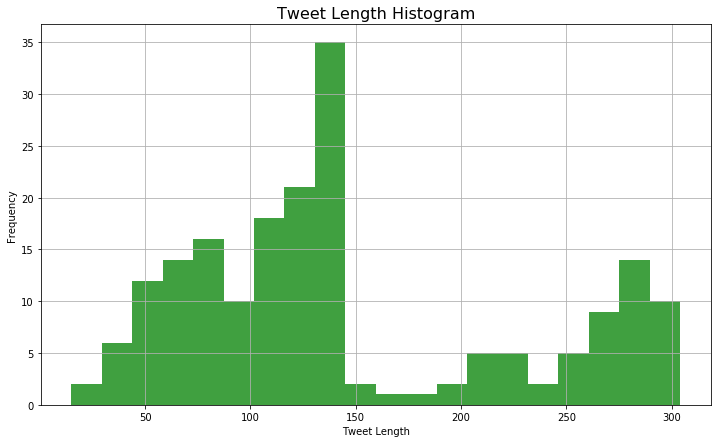

In [14]:
# Plot histograma of the tweet length
fig = plt.figure(figsize = (12, 7))
plt.hist(tweets_len, 20, facecolor='green', alpha=0.75)
plt.title('Tweet Length Histogram', fontsize=16)
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 3.2. Stats of Retweets and Favorites

In [15]:
# Retweet and favorite stats
retweet_count = []
favorite_count = []

for tweet in tweet_list:
    if not tweet['retweeted']:
        retweet_count.append(tweet['retweet_count'])
        favorite_count.append(tweet['favorite_count'])

In [16]:
# Showing stats
print('Retweets total:', np.sum(retweet_count))
print('Retweets average:', round(np.mean(retweet_count), 2))
print('Retweets total:', np.sum(favorite_count))
print('Retweets average:', round(np.mean(favorite_count), 2))

Retweets total: 79
Retweets average: 0.52
Retweets total: 209
Retweets average: 1.38


### 3.3. Tweets Language

In [17]:
# Count the language of the tweets
lang_list = Counter()
lang_dict = {'en': 'English', 'es': 'Spanish', 'de': 'Deutsch', 'und': 'Undefined'}

for tweet in tweet_list:
    lang = lang_dict[tweet['lang']]
    lang_list[lang] += 1

df = pd.DataFrame.from_records(lang_list.most_common(), columns = ['language', 'frequency'])

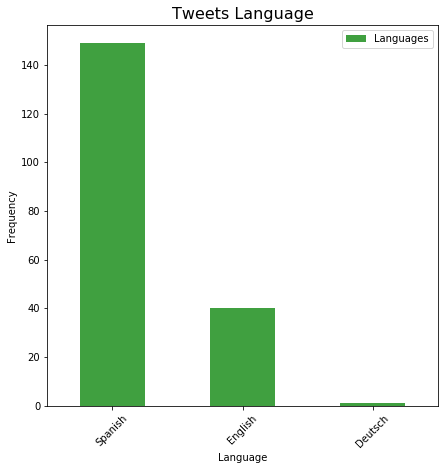

In [18]:
# Plot the the language of the tweets
fig, ax = plt.subplots()
df.plot.bar(ax=ax, x='language', y='frequency', color='green', alpha=0.75, figsize=(7, 7))
ax.legend(['Languages'])
plt.xticks(rotation=45)
plt.title('Tweets Language', fontsize=16)
plt.xlabel('Language')
plt.ylabel('Frequency')
plt.show()

### 3.4. Tweets by Day of Week and by Year

In [19]:
# Count the language of the tweets
tweets_year = Counter()
tweets_day = Counter()

for tweet in tweet_list:
    created_at = tweet['created_at'].date()
    weekday = created_at.weekday()
    year = created_at.year
    
    tweets_day[weekday] += 1
    tweets_year[year] += 1

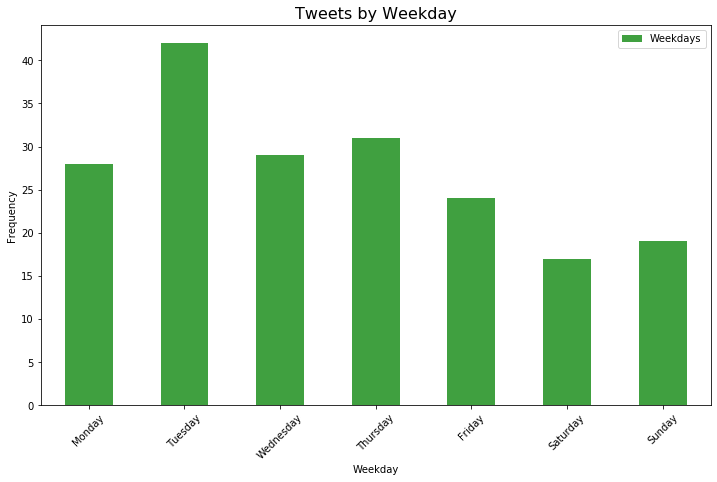

In [20]:
# Cooking dataframe
df = pd.DataFrame.from_records(list(tweets_day.items()), columns = ['weekday', 'frequency']).sort_values(by=['weekday'])
x = np.arange(7)
x_label = [calendar.day_name[d] for d in x]

# Plot the the language of the tweets
fig, ax = plt.subplots()
df.plot.bar(ax=ax, x='weekday', y='frequency', color='green', alpha=0.75, figsize=(12, 7))
ax.legend(['Weekdays'])
plt.xticks(x, x_label, rotation=45)
plt.title('Tweets by Weekday', fontsize=16)
plt.xlabel('Weekday')
plt.ylabel('Frequency')
plt.show()

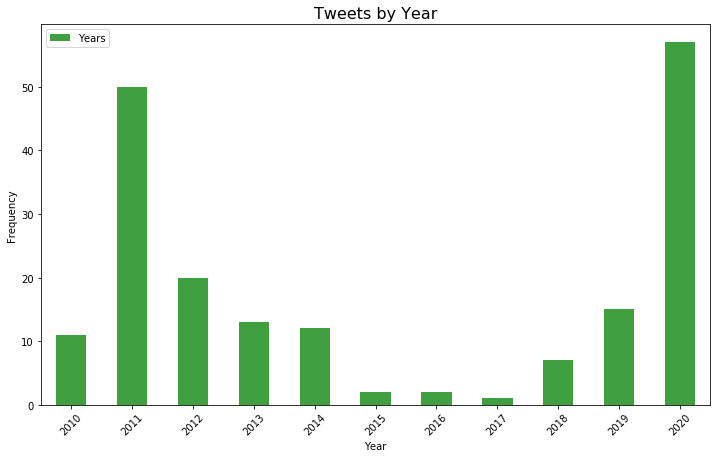

In [21]:
# Cooking dataframe
df = pd.DataFrame.from_records(tweets_year.most_common(), columns = ['year', 'frequency']).sort_values(by=['year'])

# Plot the the language of the tweets
fig, ax = plt.subplots()
df.plot.bar(ax=ax, x='year', y='frequency', color='green', alpha=0.75, figsize=(12, 7))
ax.legend(['Years'])
plt.xticks(rotation=45)
plt.title('Tweets by Year', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

### 3.5. Tweeting Sources

In [22]:
# Count the source of the tweets
tweets_source = Counter()

for tweet in tweet_list:
    year = tweet['source']
    tweets_source[year] += 1

df = pd.DataFrame.from_records(tweets_source.most_common(), columns = ['source', 'frequency'])

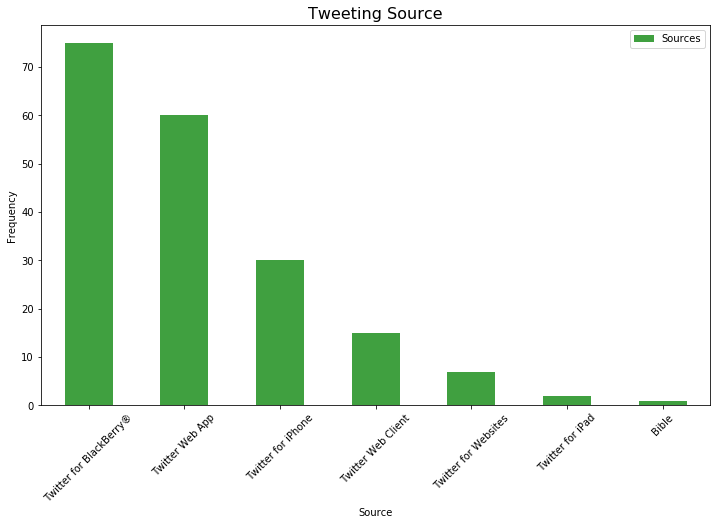

In [23]:
# Plot the the language of the tweets
fig, ax = plt.subplots()
df.plot.bar(ax=ax, x='source', y='frequency', color='green', alpha=0.75, figsize=(12, 7))
ax.legend(['Sources'])
plt.xticks(rotation=45)
plt.title('Tweeting Source', fontsize=16)
plt.xlabel('Source')
plt.ylabel('Frequency')
plt.show()

## 4. NLP Analytics

In [24]:
# Global NLP variables
n_top = 20
chars_to_remove = ['\n', '\'', '\\', '/', '.', ',', ':', ';', '!', '¿', '?', '#', '$', '%', '&', '(', ')']
rx = '[' + re.escape(''.join(chars_to_remove)) + ']'

In [25]:
# Counter of used words
word_list = Counter()

# Create list of words
for tweet in tweet_list:
    tweet_text = tweet['full_text']
    
    # Clean tweet text
    clean_text = tweet_text.lower()
    clean_text = re.sub(rx, ' ', clean_text)
    clean_text = re.sub(r'\.+', ' ', clean_text)
    clean_text = re.sub(r'\s+', ' ', clean_text)
    
    # Save mentioned accounts
    for word in clean_text.split(' '):
        if len(word) and not word.isnumeric():
            word_list[word] += 1

print('n of used words:', len(word_list))

n of used words: 1658


### 4.1. Most mentioned User Accounts

In [26]:
# Most mentioned accounts list
tw_accounts = Counter()

# Save mentioned accounts
for word, freq in list(word_list.items()):
    if word[0] == '@' and word != tw_user_name:
        tw_accounts[word] = freq

print('Top N mentioned accounts:', len(tw_accounts))

Top N mentioned accounts: 52


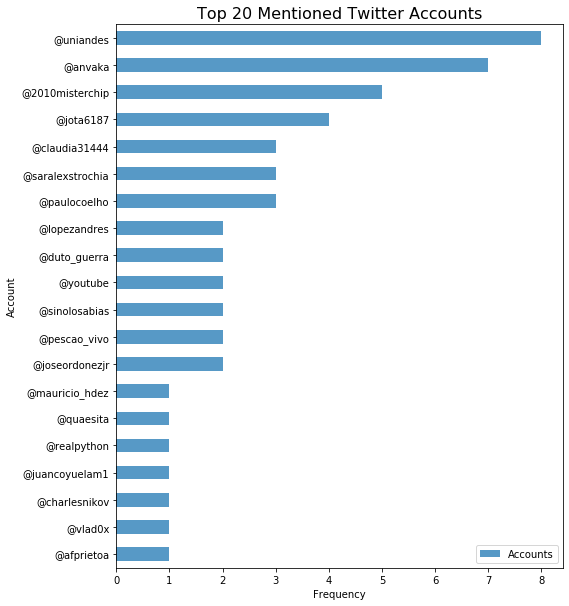

In [27]:
# Cooking dataframe
top_accounts = tw_accounts.most_common(n_top)
df = pd.DataFrame.from_records(top_accounts, columns = ['account', 'frequency']).sort_values(by=['frequency'])

# Plot top N mentioned accounts
fig, ax = plt.subplots()
df.plot.barh(ax=ax, x='account', y='frequency', alpha=0.75, figsize=(8, 10))
ax.legend(['Accounts'])
plt.title('Top %s Mentioned Twitter Accounts' % n_top, fontsize=16)
plt.xlabel('Frequency')
plt.ylabel('Account')
plt.show()

### 4.2. Most used Hashtags in Tweets

In [28]:
# Count the hashtags in the tweets and return the N most repeated 
hashtags = Counter()

for t in tweet_list:
    for ht in t['hashtags']:
        hashtags[ht] += 1

top_hashtags = hashtags.most_common(n_top)
df = pd.DataFrame.from_records(top_hashtags, columns = ['hashtag', 'frequency']).sort_values(by=['frequency'])

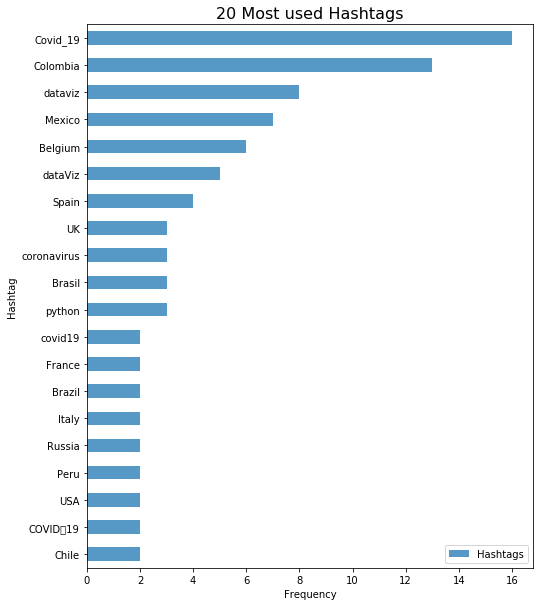

In [29]:
# Plot the most common hashtags in tweets
fig, ax = plt.subplots()
df.plot.barh(ax=ax, x='hashtag', y='frequency', alpha=0.75, figsize=(8, 10))
ax.legend(['Hashtags'])
plt.title('%s Most used Hashtags' % n_top, fontsize=16)
plt.xlabel('Frequency')
plt.ylabel('Hashtag')
plt.show()

### 4.3. Most common Words in Tweets

In [30]:
# Add word-freq to Dataframe
df = pd.DataFrame(columns=['word', 'frequency'])
ix = 0

# Filter twitter accounts
for word, freq in word_list.most_common():
    if len(word) > 2 and word[0] != '@':
        df.loc[ix] = (word, freq)
        ix += 1
    if ix == n_top:
        break

df = df.sort_values(by=['frequency'])

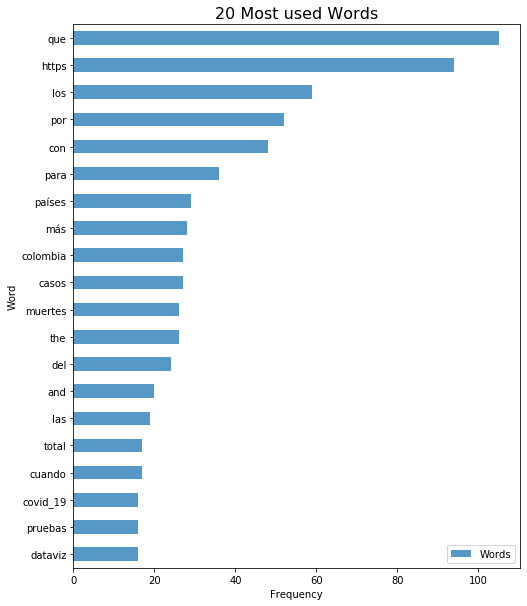

In [31]:
# Plot the most common words in tweets
fig, ax = plt.subplots()
df.plot.barh(ax=ax, x='word', y='frequency', alpha=0.75, figsize=(8, 10))
ax.legend(['Words'])
plt.title('%s Most used Words' % n_top, fontsize=16)
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

### 4.4. Most common Words w/o Stopwords

In [32]:
# Get Spanish stopwords
stopwords_es = es.stop_words.STOP_WORDS
stopwords_en = en.stop_words.STOP_WORDS | set({'http', 'https'})

In [33]:
# Add word-freq to Dataframe
df = pd.DataFrame(columns=['word', 'frequency'])
ix = 0

# Filter English and Spanihs stopwords
for word, freq in word_list.most_common():
    if (word not in stopwords_es) and (word not in stopwords_en) and (len(word) > 2) and (word[0] != '@'):
        df.loc[ix] = (word, freq)
        ix += 1
    if ix == n_top:
        break

df = df.sort_values(by=['frequency'])

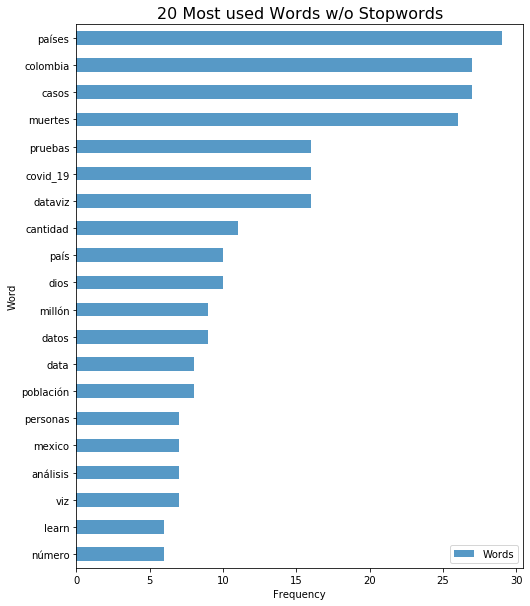

In [34]:
# Plot the most common words in tweets
fig, ax = plt.subplots()
df.plot.barh(ax=ax, x='word', y='frequency', alpha=0.75, figsize=(8, 10))
ax.legend(['Words'])
plt.title('%s Most used Words w/o Stopwords' % n_top, fontsize=16)
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

## 5. Tweet WordCloud

In [35]:
# Reconstructing the clean text (without stop-words)
new_clean_text = ''
for word, freq in list(word_list.items()):
    if (word not in stopwords_es) and (word not in stopwords_en) and (len(word) > 2) and (word[0] != '@'):
        new_clean_text = new_clean_text + word + ' '

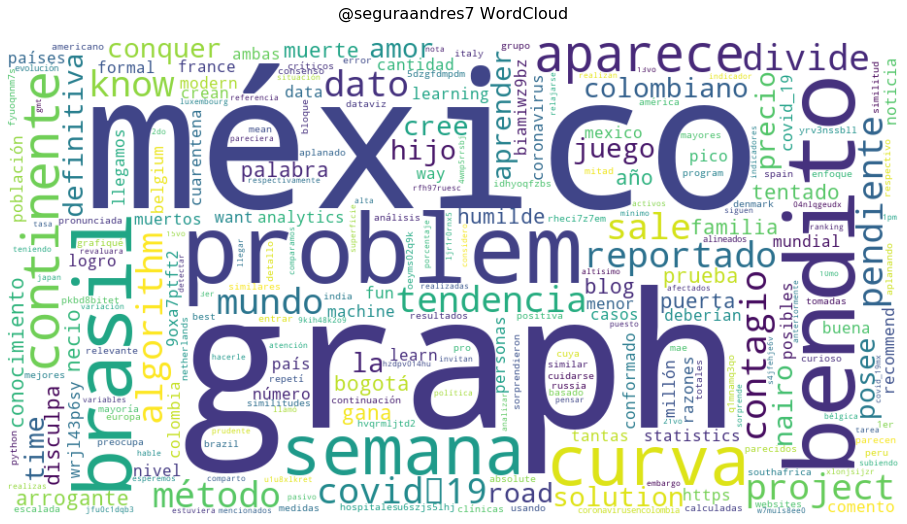

In [36]:
# Import mask
mask = np.array(Image.open('../img/twitter-mask.png'))

# Create a Word-cloud
wc = WordCloud(background_color="white", max_words=250, mask=mask, margin=2)
wc = wc.generate(new_clean_text)

# Plot a Word-cloud of words of tweets
plt.figure(figsize = (16, 10))
image = plt.imshow(wc, interpolation = "bilinear")
plt.title('%s WordCloud\n' % tw_user_name, fontsize=16)
plt.axis("off")

# Save the Word-cloud image
plt.savefig('../img/wordcloud.png')
plt.show()

<hr>
<p><a href="https://github.com/ansegura7/TwitterAnalytics">« Home</a></p>